# Assignment 1

## Task 0 - Image-I/O

There are several python libraries for reading and displaying images. I recommend scikit-image. Execute the next cell and install missing libraries like scikit-image. 

In [27]:
# imports
%matplotlib inline
from skimage import io, data, color
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

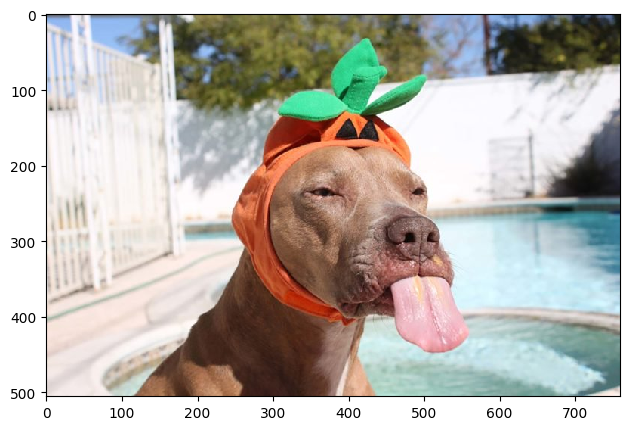

In [3]:
image = io.imread('images/dog.jpg')
io.imshow(image)

By the way, there are many test images in skimage.data that you can use for your tasks. Execute the next two cells. 

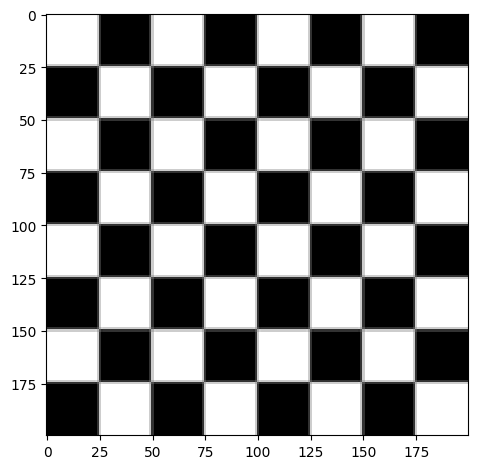

In [4]:
io.imshow(data.checkerboard())

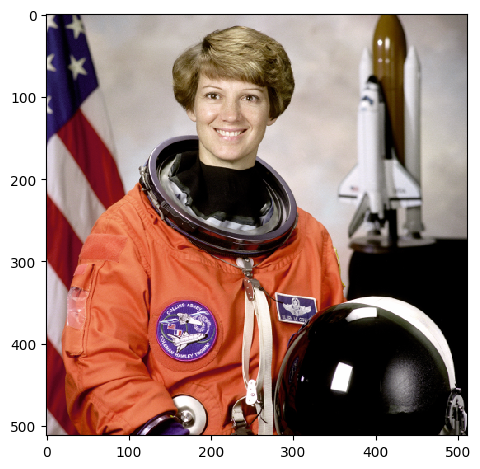

In [5]:
io.imshow(data.astronaut())

Add a line of code to the next cell to display 440 <= x <= 540 and 250 <= y <= 390 for the dog image!

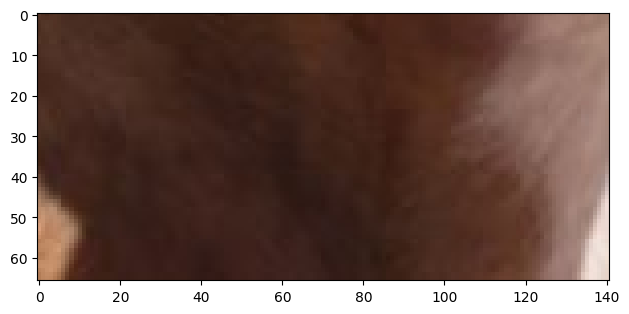

In [6]:
# code here
io.imshow(image[440:541, 250:391])

Now convert the color image to a grayscale image and display it!

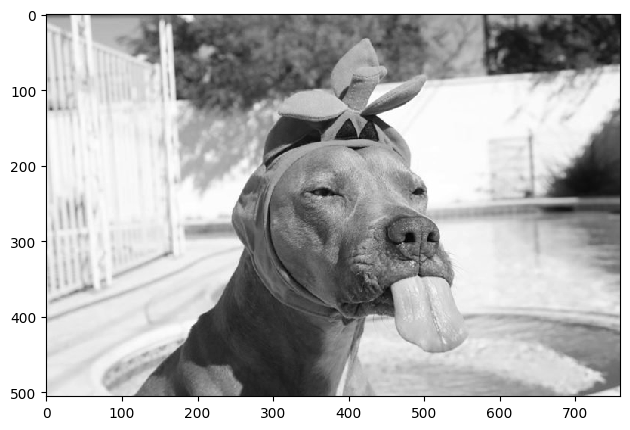

In [7]:
# code here
io.imshow(color.rgb2gray(image))

There are other color spaces. For example, HSV will be used in the lecture. Convert your image to HSV and display the H-channel.

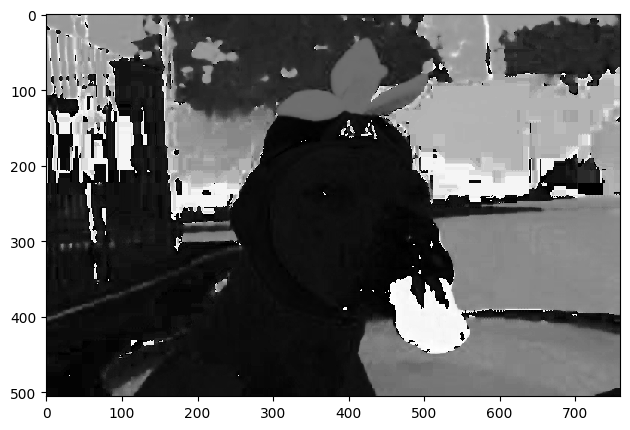

In [16]:
# code here
io.imshow(color.rgb2hsv(image)[:,:,0])

Did you know that HSV now allows creating robust (i.e. lighting independent) color histograms? Create one with Matplotlib!

(array([4.3970e+03, 5.0700e+02, 1.2470e+03, 4.0730e+03, 1.9290e+03,
        3.6880e+03, 3.2170e+03, 9.2000e+03, 1.1328e+04, 5.9180e+03,
        9.7160e+03, 1.2277e+04, 1.2356e+04, 1.2197e+04, 8.1170e+03,
        1.5431e+04, 1.2876e+04, 4.4190e+03, 1.1073e+04, 2.3550e+03,
        2.4230e+03, 3.1530e+03, 2.0990e+03, 2.5680e+03, 7.9600e+02,
        1.3310e+03, 2.1580e+03, 2.4600e+02, 1.9610e+03, 2.3880e+03,
        3.7400e+02, 1.5620e+03, 1.0040e+03, 6.6700e+02, 2.2570e+03,
        2.1090e+03, 3.4610e+03, 2.3560e+03, 2.3720e+03, 3.6080e+03,
        3.8840e+03, 3.3440e+03, 5.6710e+03, 1.3320e+03, 1.7430e+03,
        1.5000e+03, 1.0150e+03, 9.6200e+02, 1.2830e+03, 1.7120e+03,
        9.3100e+02, 9.3500e+02, 3.3300e+02, 1.5100e+02, 7.4400e+02,
        8.0000e+01, 3.8300e+02, 7.0000e+01, 9.8000e+01, 4.4100e+02,
        6.0900e+02, 9.5000e+01, 6.5000e+01, 7.2000e+01, 1.5900e+02,
        1.8200e+02, 1.8000e+01, 1.7000e+01, 3.5900e+02, 2.2000e+01,
        6.1000e+01, 4.2600e+02, 6.7000e+01, 4.39

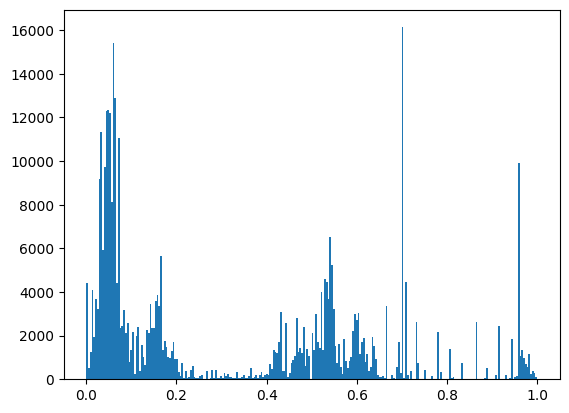

In [20]:
plt.hist(color.rgb2hsv(image)[:,:,0].ravel(), bins=256, range=(0.0, 1.0))

## Task 1 - Color Spaces and Morphological Operators

### Task 1.1

For an image of your choice, implement the simple binarization method as shown in the lecture. We've put an example image in `/images`.

* Define the „positive“ subspace P in the RGB cube
* Iterate over all pixels in I and check if in P or ~P
* Write result to new image
* Play around with size and shape of P and display binary image (**RESULT**)

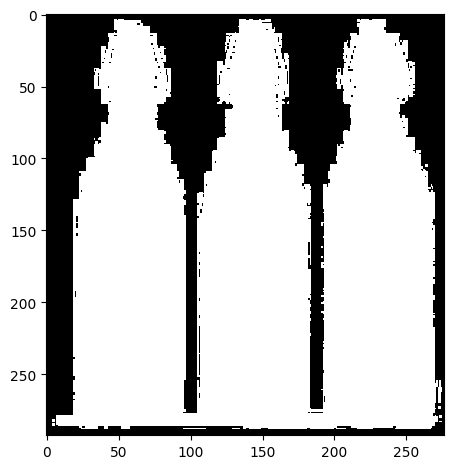

In [105]:
image = io.imread('images/bottles.png')
# io.imshow(image)

# I think the most interesting positive space is the bottles so we remove the background

# 1. Create binary image
binary = color.rgb2gray(image)
for y, row in enumerate(image):
    for x, pixel in enumerate(row):
        binary[y,x] = (tuple(pixel) != (255,)*3) / 1.0

io.imshow(binary)

### Task 1.2

* Take your binary color detection image
* Erase noise with an erosion operation
* Dilate once to get original size of object
* Find connected components with the two-pass algorithm
* Extract the bounding box on the fly
* Draw the bounding box on original image (**RESULT**)

In [ ]:
# morphology
from skimage.morphology import binary_erosion, binary_dilation, binary_closing, binary_opening

# close the "holes" in the bottles
binary = binary_closing(binary)

# disconnect the bottles and smooth the edges a bit
for _ in range(15):
    binary = binary_erosion(binary)
for _ in range(15):
    binary = binary_dilation(binary)

[0 1 3 4]


c:\Users\rharv\Downloads\Computer Vision\venv\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


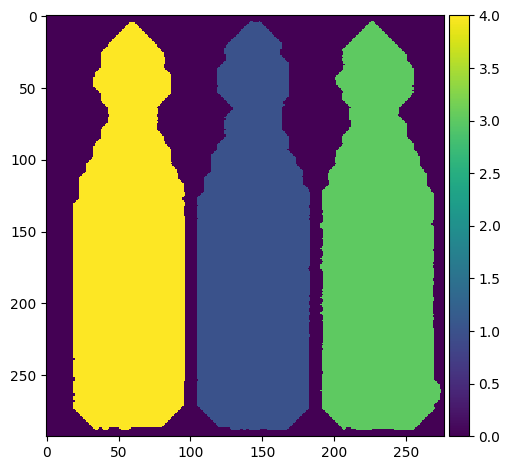

In [118]:
# connected components
mark = np.zeros_like(binary, dtype=np.int64)
current_mark = 0

def get_mark():
    global current_mark
    current_mark += 1
    return current_mark

def neighbors(y: int, x: int):
    return [(y, x-1), (y, x+1), (y-1, x), (y+1, x)]

# first pass
for y, row in enumerate(binary):
    for x, pixel in enumerate(row):
        if not pixel:
            continue
        marks = [
            mark[n] for n in neighbors(y,x)
            if 0 <= n[1] < len(row) 
            and 0 <= n[0] < len(binary) 
            and binary[n] 
            and mark[n]
        ]
        mark[y,x] = min(marks) if marks else get_mark()

# further passes 
# (two passes are never sufficient using the method suggested in the lecture)
components = 0
while components != len(np.unique_values(mark)):
    components = len(np.unique_values(mark))
    for y, row in enumerate(binary):
        for x, pixel in enumerate(row):
            if not pixel:
                continue
            old_mark = mark[y,x]
            mark[y,x] = min(
                mark[n] for n in [(y,x), *neighbors(y,x)]
                if 0 <= n[1] < len(row) and 0 <= n[0] < len(binary) and binary[n]
            )
            # if old_mark != mark[y,x]:
            #     print(x, y, old_mark, mark[y,x])
            assert mark[y,x], (mark[y,x], y,x)

# 0 is the background, all other values are connected components
print(np.unique_values(mark))
io.imshow(mark)

4 105 288 183
4 191 288 274
5 19 288 96


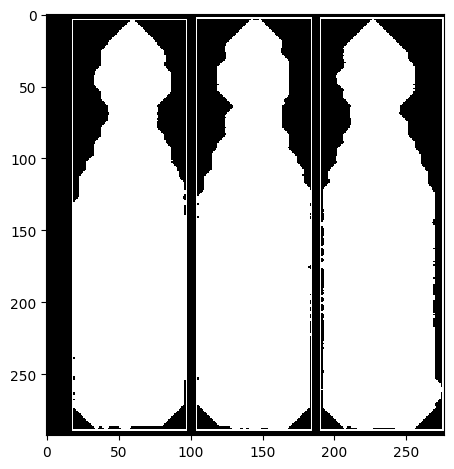

In [121]:
# for drawing bounding boxes
from skimage import draw

# find bounding boxes
for component in np.unique_values(mark):
    if not component:
        continue
    ys, xs = np.where(mark == component)
    top, left = ys.min(), xs.min()
    bottom, right = ys.max(), xs.max()

    print(top, left, bottom, right)

    # draw bounding box
    binary[
        draw.rectangle_perimeter((top, left), (bottom, right), shape = image.shape)
    ] = 1

io.imshow(binary)

### Task 1.3

* Use your color detection and connected components algorithm
* Implement simplest tracking algorithm
* Draw history of all previous points on the frame (**RESULT**)

(see images/racecar or images/taco for sample image sequences)

In [ ]:
# code here

### Task 1.4 (BONUS)

* Find connected components using a one-pass algorithm in your image from Task 1.2
* Plot the resulting image and compare it to the result of your two-pass implementation (**RESULT**)

In [ ]:
# code here